In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Rescaling,Resizing, RandomFlip, RandomRotation
import time
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names

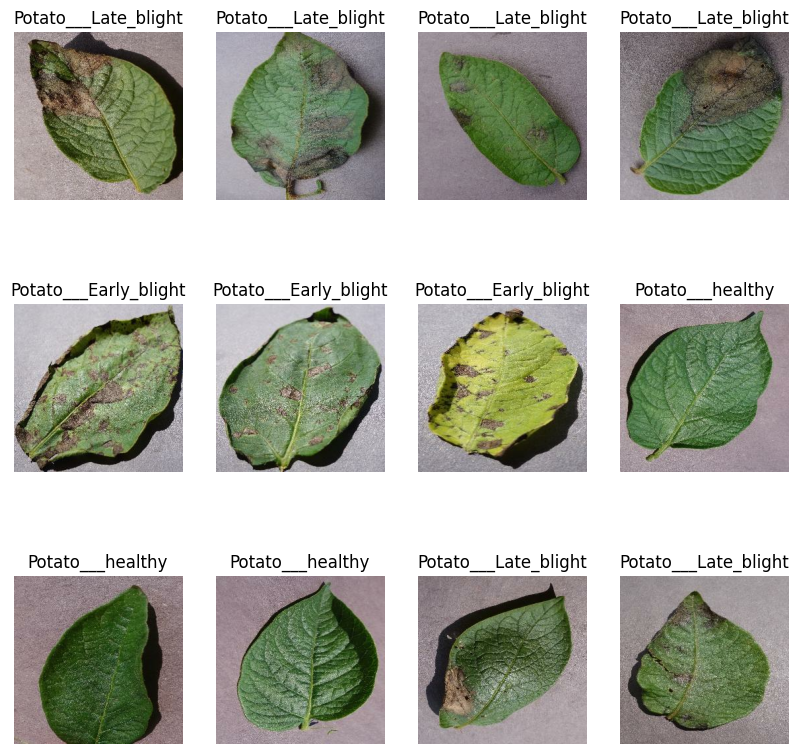

In [5]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("int"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds  = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [9]:
resize_and_rescale  = tf.keras.Sequential([
    Rescaling(1.0/255),
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
])

In [10]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])

In [11]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

custom_model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation = "relu", input_shape = input_shape),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D(pool_size = (2,2)),
    layers.Flatten(),
    layers.Dense(128, activation = "relu"),
    layers.Dense(n_classes, activation = "softmax"),
])

custom_model.build(input_shape = input_shape)

c:\Users\Sahil\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
custom_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 128)              │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,387 (782.76 KB)

 Trainable params: 200,387 (782.76 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
def evaluate_model(model, test_ds):
    y_true = []
    y_pred = []
    
    for images, labels in test_ds:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(tf.argmax(predictions, axis=1).numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1

In [14]:
model_results = {}

In [15]:
def train_and_evaluate(model, model_name, train_ds, val_ds, test_ds, EPOCHS):
    # Step 1: Measure Training Time
    start_time = time.time()
    history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=1)
    total_training_time = time.time() - start_time
    average_time_per_epoch = total_training_time / EPOCHS

    # Step 2: Evaluate Test Metrics
    accuracy, precision, recall, f1 = evaluate_model(model, test_ds)

    # Store the results in the dictionary
    model_results[model_name] = {
        'training_time': total_training_time,
        'avg_time_per_epoch': average_time_per_epoch,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    print(f"\n{model_name} - Training Completed!")
    print(f"Total training time: {total_training_time:.2f} seconds")
    print(f"Average time per epoch: {average_time_per_epoch:.2f} seconds")
    print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}\n")

In [16]:
custom_model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [17]:
from tensorflow.keras.applications import VGG16

vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
vgg16_model.trainable = False

vgg16_model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    vgg16_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

vgg16_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
from tensorflow.keras.applications import ResNet50

resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
resnet50_model.trainable = False

resnet50_model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    resnet50_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])
resnet50_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
from tensorflow.keras.applications import MobileNet

mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
mobilenet_model.trainable = False

mobilenet_model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    mobilenet_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

mobilenet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

C:\Users\Sahil\AppData\Local\Temp\ipykernel_34120\3887724752.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))


In [20]:
from tensorflow.keras.applications import EfficientNetB0

efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
efficientnet_model.trainable = False

efficientnet_model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    efficientnet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

efficientnet_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
train_and_evaluate(custom_model, "Custom Model", train_ds, val_ds, test_ds, EPOCHS)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 56s 844ms/step - accuracy: 0.4858 - loss: 0.9347 - val_accuracy: 0.6771 - val_loss: 0.6296
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 623ms/step - accuracy: 0.7085 - loss: 0.6205 - val_accuracy: 0.7865 - val_loss: 0.4690
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 646ms/step - accuracy: 0.7892 - loss: 0.4562 - val_accuracy: 0.8698 - val_loss: 0.3257
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 637ms/step - accuracy: 0.8460 - loss: 0.3954 - val_accuracy: 0.8750 - val_loss: 0.3598
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 558ms/step - accuracy: 0.8624 - loss: 0.3507 - val_accuracy: 0.8438 - val_loss: 0.3626
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 552ms/step - accuracy: 0.9078 - loss: 0.2148 - val_accuracy: 0.8698 - val_loss: 0.2687
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 30s 548ms/step - accuracy: 0.9305 - loss: 0.1744 - val_accuracy: 0.9635 - val_loss: 0.1288
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 546ms/step - accuracy: 0.9635 - loss: 0.1061 - val_accu

In [22]:
train_and_evaluate(vgg16_model, "VGG16", train_ds, val_ds, test_ds, EPOCHS)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.6852 - loss: 2.2351 - val_accuracy: 0.8646 - val_loss: 0.2640
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.9125 - loss: 0.2184 - val_accuracy: 0.8385 - val_loss: 0.4879
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.9135 - loss: 0.2799 - val_accuracy: 0.9271 - val_loss: 0.1632
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.9429 - loss: 0.1634 - val_accuracy: 0.9583 - val_loss: 0.1670
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.9431 - loss: 0.1799 - val_accuracy: 0.9427 - val_loss: 0.1287
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.9577 - loss: 0.1218 - val_accuracy: 0.9375 - val_loss: 0.1473
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.9550 - loss: 0.1347 - val_accuracy: 0.9740 - val_loss: 0.1455
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.9696 - loss: 0.0827 - val_accuracy: 0.9688 - v

In [23]:
train_and_evaluate(resnet50_model, "ResNet50", train_ds, val_ds, test_ds, EPOCHS)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.5642 - loss: 10.5035 - val_accuracy: 0.6667 - val_loss: 0.8833
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.6920 - loss: 1.1575 - val_accuracy: 0.6198 - val_loss: 1.1475
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.8015 - loss: 0.7115 - val_accuracy: 0.5833 - val_loss: 2.1378
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.7626 - loss: 0.8329 - val_accuracy: 0.7500 - val_loss: 0.8464
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.7167 - loss: 1.0501 - val_accuracy: 0.8021 - val_loss: 0.7850
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.7756 - loss: 0.8553 - val_accuracy: 0.7604 - val_loss: 0.9937
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.7861 - loss: 0.8191 - val_accuracy: 0.8385 - val_loss: 0.7745
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.7897 - loss: 0.7352 - val_accuracy: 0.7083 - 

In [24]:
train_and_evaluate(mobilenet_model, "MobileNet", train_ds, val_ds, test_ds, EPOCHS)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 50s 876ms/step - accuracy: 0.4678 - loss: 13.5399 - val_accuracy: 0.8125 - val_loss: 0.6388
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 861ms/step - accuracy: 0.8348 - loss: 0.6398 - val_accuracy: 0.8854 - val_loss: 0.5916
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 861ms/step - accuracy: 0.8846 - loss: 0.5987 - val_accuracy: 0.8906 - val_loss: 0.5436
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 856ms/step - accuracy: 0.8916 - loss: 0.5775 - val_accuracy: 0.8906 - val_loss: 0.5156
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 879ms/step - accuracy: 0.8992 - loss: 0.5350 - val_accuracy: 0.8958 - val_loss: 0.4929
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 858ms/step - accuracy: 0.9064 - loss: 0.5015 - val_accuracy: 0.8802 - val_loss: 0.4166
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 860ms/step - accuracy: 0.9050 - loss: 0.3744 - val_accuracy: 0.8958 - val_loss: 0.2292
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 863ms/step - accuracy: 0.9136 - loss: 0.1945 - val_acc

In [25]:
train_and_evaluate(efficientnet_model, "EfficientNet", train_ds, val_ds, test_ds, EPOCHS)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.4257 - loss: 0.9513 - val_accuracy: 0.4896 - val_loss: 0.9346
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.4643 - loss: 0.9142 - val_accuracy: 0.4896 - val_loss: 0.9234
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.4270 - loss: 0.9372 - val_accuracy: 0.4896 - val_loss: 0.9244
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.4552 - loss: 0.9346 - val_accuracy: 0.4896 - val_loss: 0.9207
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.4476 - loss: 0.9326 - val_accuracy: 0.4896 - val_loss: 0.9408
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.4614 - loss: 0.9317 - val_accuracy: 0.4271 - val_loss: 0.9871
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.4498 - loss: 0.8938 - val_accuracy: 0.4271 - val_loss: 0.9365
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.4763 - loss: 0.9003 - val_accuracy: 0.4896 - val_loss:

c:\Users\Sahil\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


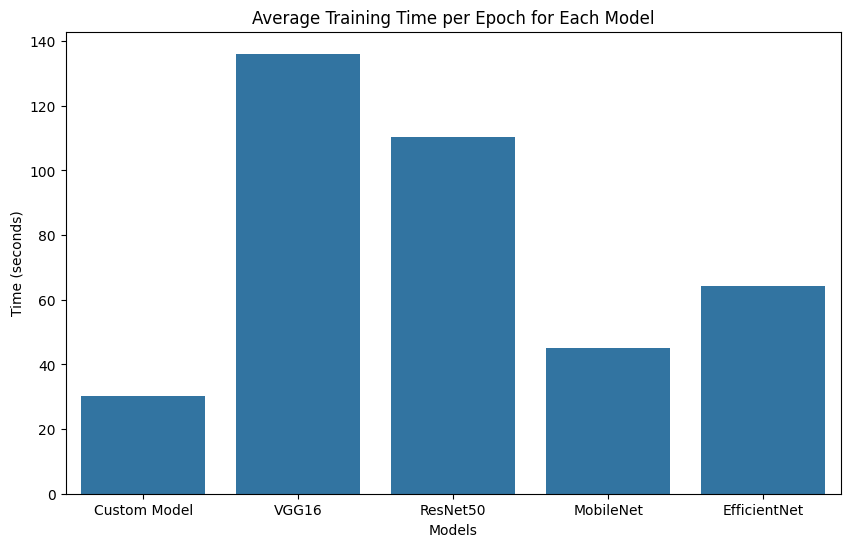

In [26]:
avg_time_per_epoch_data = {model: model_results[model]['avg_time_per_epoch'] for model in model_results}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(avg_time_per_epoch_data.keys()), y=list(avg_time_per_epoch_data.values()))
plt.title('Average Training Time per Epoch for Each Model')
plt.ylabel('Time (seconds)')
plt.xlabel('Models')
plt.show()

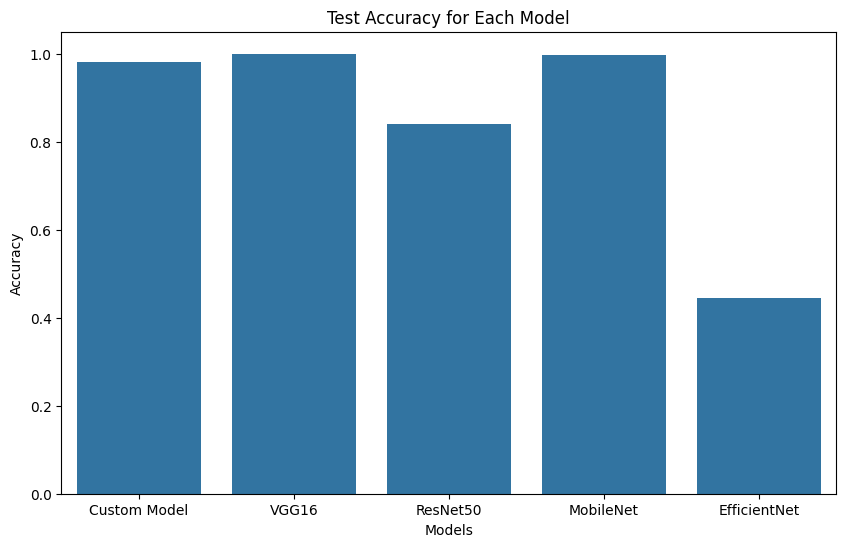

In [27]:
accuracy_data = {model: model_results[model]['accuracy'] for model in model_results}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracy_data.keys()), y=list(accuracy_data.values()))
plt.title('Test Accuracy for Each Model')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.show()

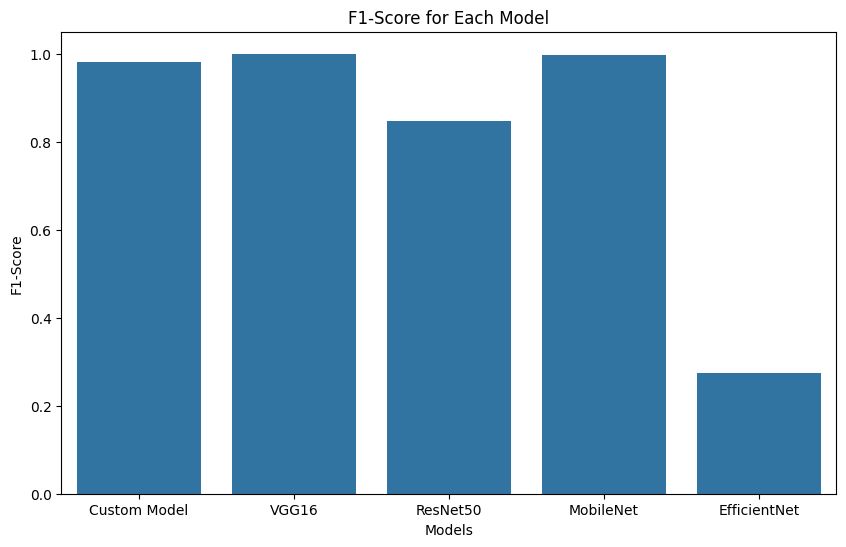

In [28]:
f1_score_data = {model: model_results[model]['f1'] for model in model_results}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(f1_score_data.keys()), y=list(f1_score_data.values()))
plt.title('F1-Score for Each Model')
plt.ylabel('F1-Score')
plt.xlabel('Models')
plt.show()

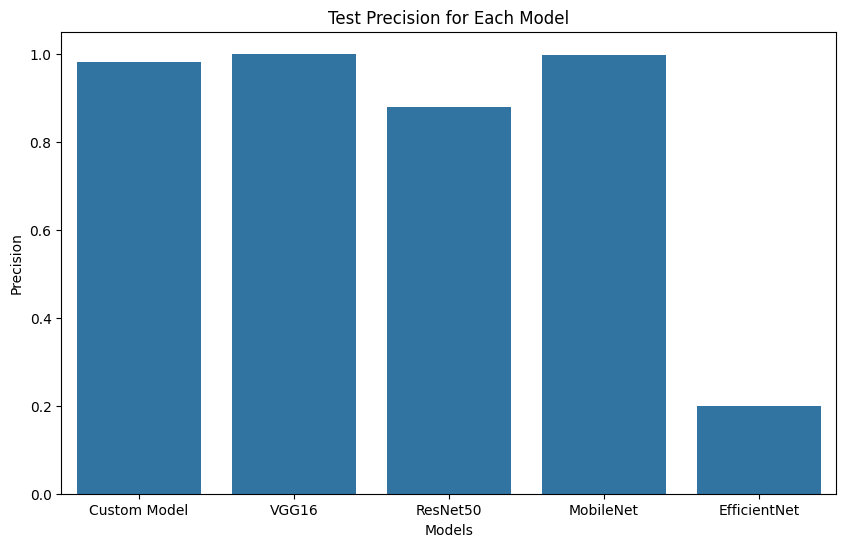

In [29]:
precision_data = {model: model_results[model]['precision'] for model in model_results}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(precision_data.keys()), y=list(precision_data.values()))
plt.title('Test Precision for Each Model')
plt.ylabel('Precision')
plt.xlabel('Models')
plt.show()

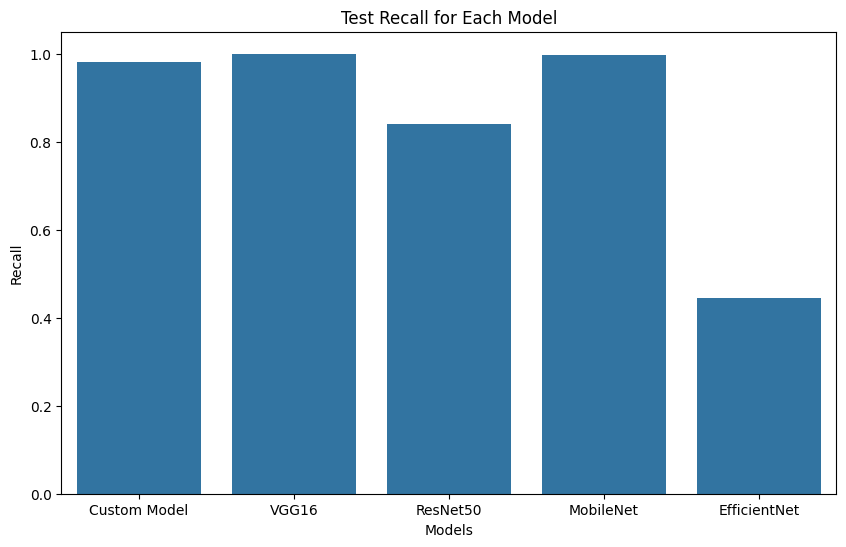

In [30]:
recall_data = {model: model_results[model]['recall'] for model in model_results}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(recall_data.keys()), y=list(recall_data.values()))
plt.title('Test Recall for Each Model')
plt.ylabel('Recall')
plt.xlabel('Models')
plt.show()

In [31]:
total_images = 0

for image_batch, label_batch in dataset:
    total_images += image_batch.shape[0]

print(f"Total number of instances (images): {total_images}")

Total number of instances (images): 2152


In [32]:
import numpy as np

# Assuming test_ds is already created as your test dataset
y_true = []

# Iterate through the test dataset to collect true labels
for image_batch, label_batch in test_ds:
    y_true.append(label_batch.numpy())  # Convert TensorFlow tensors to NumPy arrays

# Flatten the list of arrays into a single array of labels
y_true = np.concatenate(y_true)

print(f"True labels: {y_true}")


True labels: [0 1 2 1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 2
 0 0 1 0 0 0 1 1 1 2 0 1 1 1 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 2 1 0 0 1 0 0 0
 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 1 0 2 0 1 1 2 0 0 1 1 1 1 1 1
 1 0 0 0 1 0 1 1 1 0 1 0 0 1 1 1 1 0 2 0 1 0 0 1 0 1 1 0 1 0 1 0 1 2 1 0 0
 0 0 2 1 2 1 0 1 1 0 1 1 0 1 0 0 2 2 1 0 0 1 1 0 1 1 1 0 0 1 1 2 1 1 1 1 1
 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 2 1 1 0 1 1 2 0 0 1 1
 1 1 0 2 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 1 0 1 1 1 1]


In [33]:
import numpy as np

# Assuming your custom model is already trained and test_ds is your test dataset
# Use model.predict() to get the predicted probabilities for each image in the test dataset

y_pred_custom = []

# Iterate through the test dataset to get predictions
for image_batch, label_batch in test_ds:
    # Predict the probabilities for each batch
    predictions = custom_model.predict(image_batch)
    
    # Convert the predicted probabilities to class labels using np.argmax
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Append predicted labels to y_pred_custom
    y_pred_custom.append(predicted_labels)

# Flatten the list of predicted labels into a single array
y_pred_custom = np.concatenate(y_pred_custom)

print(f"Predicted labels from Custom Model: {y_pred_custom}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Predicted labels from Custom Model: [0 1 2 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 1 0 0 0 2
 0 0 1 0 0 0 1 1 1 2 0 1 1 1 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 0 0 2 2 1 0 0 1
 1 0 1 1 1 0 0 1 1 2 1 1 1 1 1 0 0 0 1 0 1 0 0 2 0 0 1 1 0 0 0 0 2 1 0 1 1
 1 1 0 0 1 0 0 1 0 1 1 1 0 1 1 1 1 0 2 0 1 0 0 1 0 1 1 0 1 0 1 0 1 2 1 0 0
 0 0 2 1 2 1 0 1 1 0 1 1 1 0 2 0 1 1 2 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0
 1 0 0 1 1 0 1 0 1 2 1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0
 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 2 1 1 0 1 1 2 0 0 1 1 1 1]


In [34]:
import numpy as np

# Assuming your custom model is already trained and test_ds is your test dataset
# Use model.predict() to get the predicted probabilities for each image in the test dataset

y_pred_vgg16 = []

# Iterate through the test dataset to get predictions
for image_batch, label_batch in test_ds:
    # Predict the probabilities for each batch
    predictions = vgg16_model.predict(image_batch)
    
    # Convert the predicted probabilities to class labels using np.argmax
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Append predicted labels to y_pred_custom
    y_pred_vgg16.append(predicted_labels)

# Flatten the list of predicted labels into a single array
y_pred_vgg16 = np.concatenate(y_pred_vgg16)

print(f"Predicted labels from VGG16 Model: {y_pred_vgg16}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted labels from VGG16 Model: [1 0 0 0 2 0 0 1 0 0 0 1 1 1 2 0 1 1 1 0 0 1 0 1 1 0 0 0 1 0 1 1 0 1 2 1 0
 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 2 1 0 0 1 1 1 1
 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 2 0 1 1 2 0 0 1 1 1 1 1 1
 1 0 0 0 1 0 1 1 1 0 1 0 0 1 1 1 1 0 2 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1
 0 0 1 0 1 1 1 0 1 1 1 1 0 1 0 0 2 2 1 0 0 1 1 0 1 1 1 0 0 1 1 2 1 1 1 1 1
 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 2 1 1 0 1 1 2 0 0 1 1
 1 1 0 2 0 1 0 0 1 0 1 1 0 1 0 1 0 1 2 1 0 0 0 0 2 1 2 1 0 1 1 0 1 1]


In [35]:
import numpy as np

# Assuming your custom model is already trained and test_ds is your test dataset
# Use model.predict() to get the predicted probabilities for each image in the test dataset

y_pred_resnet50 = []

# Iterate through the test dataset to get predictions
for image_batch, label_batch in test_ds:
    # Predict the probabilities for each batch
    predictions = resnet50_model.predict(image_batch)
    
    # Convert the predicted probabilities to class labels using np.argmax
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Append predicted labels to y_pred_custom
    y_pred_resnet50.append(predicted_labels)

# Flatten the list of predicted labels into a single array
y_pred_resnet50 = np.concatenate(y_pred_resnet50)

print(f"Predicted labels from Resnet50 Model: {y_pred_resnet50}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted labels from Resnet50 Model: [1 0 0 0 2 0 0 2 0 0 0 1 1 1 2 0 2 1 0 0 0 1 0 1 1 0 0 0 2 0 1 0 0 1 0 0 2
 0 1 0 0 1 1 0 1 1 1 0 0 1 1 2 1 1 1 0 1 1 0 0 2 0 1 0 1 0 2 2 1 1 2 0 0 0
 1 1 0 0 1 0 0 0 0 1 0 2 1 1 0 1 0 0 1 1 1 0 0 1 2 1 0 0 1 1 1 1 0 1 2 0 0
 0 0 0 1 0 1 0 0 0 0 2 0 0 1 0 1 0 0 2 0 0 1 1 0 0 0 0 0 1 0 2 1 2 1 0 0 1
 0 0 1 0 1 1 1 0 1 0 1 1 0 2 0 1 0 0 2 0 1 0 0 1 0 0 0 1 1 1 0 0 0 0 2 0 1
 1 1 1 1 0 1 2 0 1 2 0 0 0 1 0 0 0 1 0 0 0 1 1 2 1 0 2 1 0 1 0 2 2 0 1 0 1
 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 2 1 0 0 0 2 2 1 1 0 1 1 2 0 0 1 1 1 2]


In [36]:
import numpy as np

# Assuming your custom model is already trained and test_ds is your test dataset
# Use model.predict() to get the predicted probabilities for each image in the test dataset

y_pred_mobilenet = []

# Iterate through the test dataset to get predictions
for image_batch, label_batch in test_ds:
    # Predict the probabilities for each batch
    predictions = mobilenet_model.predict(image_batch)
    
    # Convert the predicted probabilities to class labels using np.argmax
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Append predicted labels to y_pred_custom
    y_pred_mobilenet.append(predicted_labels)

# Flatten the list of predicted labels into a single array
y_pred_mobilenet = np.concatenate(y_pred_mobilenet)

print(f"Predicted labels from Mobilenet Model: {y_pred_mobilenet}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 703ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 708ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 663ms/step
Predicted labels from Mobilenet Model: [0 1 2 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 2 0 1 0
 0 1 0 1 1 0 1 0 1 0 1 2 1 0 0 0 0 2 1 2 1 0 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0
 0 0 0 0 1 0 0 0 1 2 1 1 0 1 1 1 0 0 1 1 1 1 0 1 2 1 0 0 1 1 1 1 0 1 1 0 0
 0 0 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0 2 2 1 0 0 1 1 0 1 1 1 0 0 1 1 2
 1 1 1 1 1 1 0 0 1 0 1 0 0 2 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1
 1 1 0 1 1 1 1 1 0 2 0 1 1 2 0 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 1
 1 1 1 0 0 0 2 0 0 1 0 0 0 1 1 1 2 0 1 1 1 0 0 1 0 1 1 0 0 0 1 0 1 1]


In [37]:
import numpy as np

# Assuming your custom model is already trained and test_ds is your test dataset
# Use model.predict() to get the predicted probabilities for each image in the test dataset

y_pred_efficientnet = []

# Iterate through the test dataset to get predictions
for image_batch, label_batch in test_ds:
    # Predict the probabilities for each batch
    predictions = efficientnet_model.predict(image_batch)
    
    # Convert the predicted probabilities to class labels using np.argmax
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Append predicted labels to y_pred_custom
    y_pred_efficientnet.append(predicted_labels)

# Flatten the list of predicted labels into a single array
y_pred_efficientnet = np.concatenate(y_pred_efficientnet)

print(f"Predicted labels from Efficientnet Model: {y_pred_efficientnet}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted labels from Efficientnet Model: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [38]:
from sklearn.metrics import cohen_kappa_score

kappa_custom = cohen_kappa_score(y_true, y_pred_custom)
kappa_vgg16 = cohen_kappa_score(y_true, y_pred_vgg16)
kappa_resnet = cohen_kappa_score(y_true, y_pred_resnet50)
kappa_mobilenet = cohen_kappa_score(y_true, y_pred_mobilenet)
kappa_efficientnet = cohen_kappa_score(y_true, y_pred_efficientnet)


print(f"Cohen's Kappa for Custom Model: {kappa_custom}")
print(f"Cohen's Kappa for VGG16 Model: {kappa_vgg16}")
print(f"Cohen's Kappa for ResNet50 Model: {kappa_resnet}")
print(f"Cohen's Kappa for MobileNet Model: {kappa_mobilenet}")
print(f"Cohen's Kappa for EfficientNet Model: {kappa_efficientnet}")

Cohen's Kappa for Custom Model: 0.29289503910736747
Cohen's Kappa for VGG16 Model: 0.31795209843990335
Cohen's Kappa for ResNet50 Model: -0.03538252791984142
Cohen's Kappa for MobileNet Model: 0.005565044906055472
Cohen's Kappa for EfficientNet Model: 0.0


In [39]:
from sklearn.metrics import mean_absolute_error
import numpy as np


mae_custom = mean_absolute_error(y_true, y_pred_custom)
mae_vgg16 = mean_absolute_error(y_true, y_pred_vgg16)
mae_resnet50 = mean_absolute_error(y_true, y_pred_resnet50)
mae_mobilenet = mean_absolute_error(y_true, y_pred_mobilenet)
mae_efficientnet = mean_absolute_error(y_true, y_pred_efficientnet)

# Print the result
print(f"Mean Absolute Error (MAE) for Custom Model: {mae_custom}")
print(f"Mean Absolute Error (MAE) for VGG16 Model: {mae_vgg16}")
print(f"Mean Absolute Error (MAE) for Resnet50 Model: {mae_resnet50}")
print(f"Mean Absolute Error (MAE) for MobileNet Model: {mae_mobilenet}")
print(f"Mean Absolute Error (MAE) for EfficientNet Model: {mae_efficientnet}")


Mean Absolute Error (MAE) for Custom Model: 0.42578125
Mean Absolute Error (MAE) for VGG16 Model: 0.3984375
Mean Absolute Error (MAE) for Resnet50 Model: 0.65234375
Mean Absolute Error (MAE) for MobileNet Model: 0.58984375
Mean Absolute Error (MAE) for EfficientNet Model: 0.6171875


In [41]:
model_results

{'Custom Model': {'training_time': 1516.9831857681274,
  'avg_time_per_epoch': 30.339663715362548,
  'accuracy': 0.98046875,
  'precision': 0.9812281904287139,
  'recall': 0.98046875,
  'f1': 0.9804649491653235},
 'VGG16': {'training_time': 6805.071392297745,
  'avg_time_per_epoch': 136.1014278459549,
  'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0},
 'ResNet50': {'training_time': 5522.654935836792,
  'avg_time_per_epoch': 110.45309871673584,
  'accuracy': 0.83984375,
  'precision': 0.8794790757671078,
  'recall': 0.83984375,
  'f1': 0.847192066486178},
 'MobileNet': {'training_time': 2246.324357032776,
  'avg_time_per_epoch': 44.92648714065552,
  'accuracy': 0.99609375,
  'precision': 0.9961245078740157,
  'recall': 0.99609375,
  'f1': 0.9960384658294021},
 'EfficientNet': {'training_time': 3207.2990646362305,
  'avg_time_per_epoch': 64.14598129272461,
  'accuracy': 0.4453125,
  'precision': 0.19830322265625,
  'recall': 0.4453125,
  'f1': 0.2744087837837838}}

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step


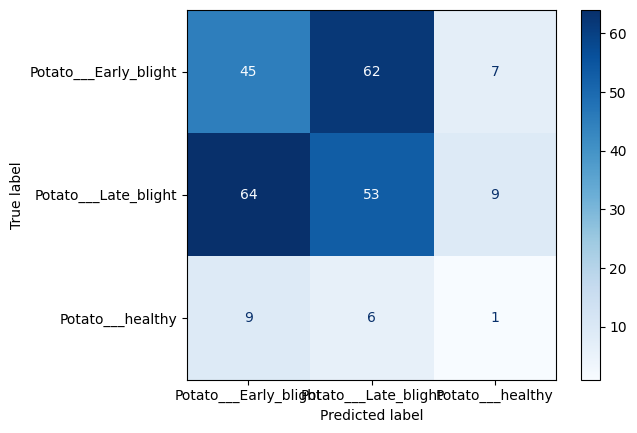

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict using one of your models
y_pred = custom_model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step


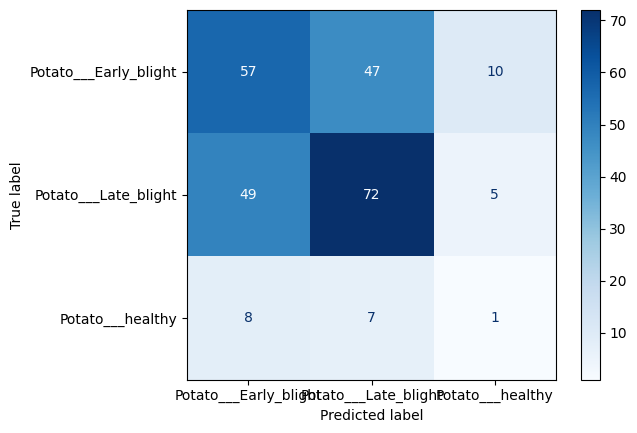

In [43]:
y_pred = vgg16_model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step


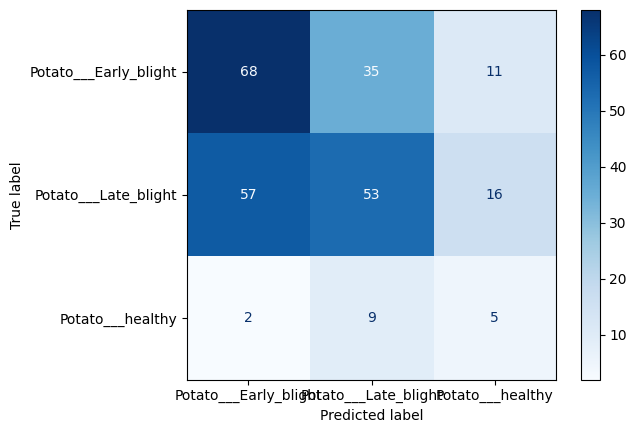

In [44]:
y_pred = resnet50_model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 855ms/step


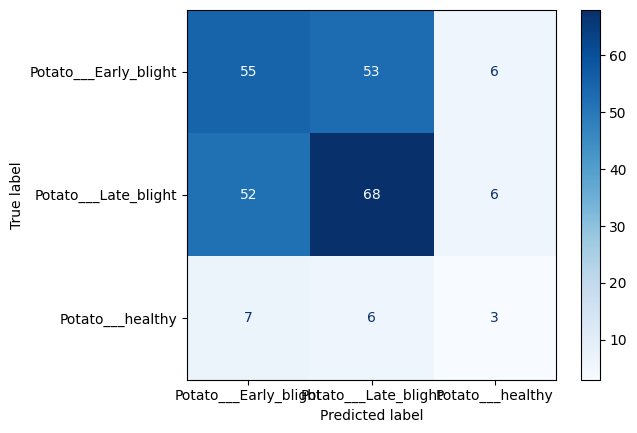

In [45]:
y_pred = mobilenet_model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


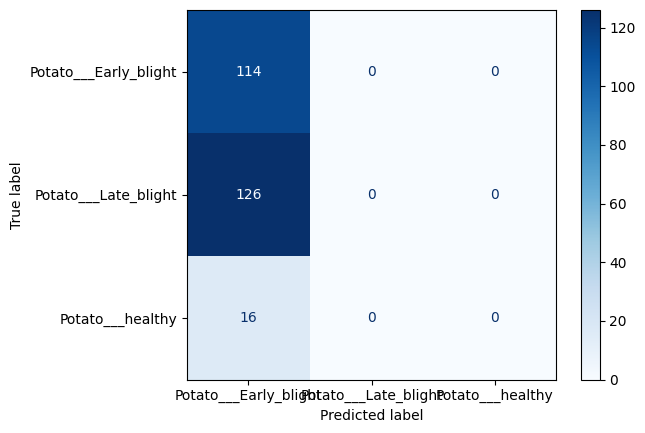

In [46]:
y_pred = efficientnet_model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 254ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 708ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


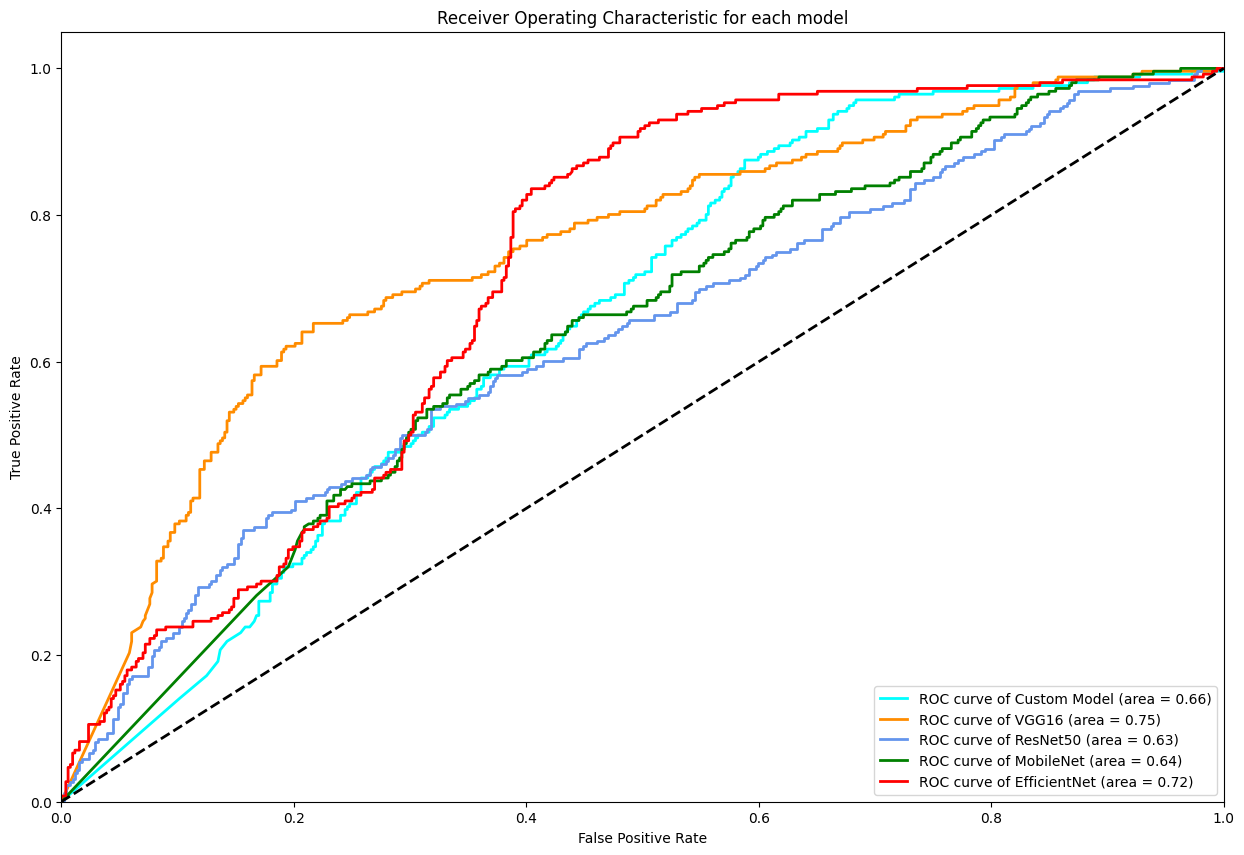

In [48]:
models = {
    "Custom Model": custom_model,
    "VGG16": vgg16_model,
    "ResNet50": resnet50_model,
    "MobileNet": mobilenet_model,
    "EfficientNet": efficientnet_model
}
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Generate predictions for each model
y_preds = {}
for model_name, model in models.items():
    y_preds[model_name] = model.predict(test_ds)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt

# Binarize the output
y_true_binarized = label_binarize(y_true, classes=range(len(class_names)))

# Initialize figure
plt.figure(figsize=(15, 10))

# Colors for each model's curve
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])

for (model_name, y_pred), color in zip(y_preds.items(), colors):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve for the micro-average
    plt.plot(fpr["micro"], tpr["micro"], color=color, lw=2,
             label='ROC curve of {} (area = {:0.2f})'.format(model_name, roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each model')
plt.legend(loc="lower right")
plt.show()